# Stereo SLAM

This is a major part of this project and will likely take some time. 

For stereo, feel free to look up existing tutorials that implement this and write your own code here. Do not spend too long tweaking parameters here, focus on getting decent results and move on. You can also use OpenCV functions to backproject to 3D. 

## PART 1: Stereo dense reconstruction

3-D point clouds are very useful in robotics for several tasks such as object detection, motion estimation (3D-3D matching or 3D-2D matching), SLAM, and other forms of scene understanding.  Stereo camerasprovide  us  with  a  convenient  way  to  generate  dense  point  clouds.Densehere,  in  contrast  tosparse,means all the image points are used for the reconstruction.  In this part of the assignment you will begenerating a dense 3D point cloud reconstruction of a scene from stereo images.

#### Procedure: 

<ol>
    <li> Generate a disparity map for each stereo pair.  Use OpenCV (e.g.  StereoSGBM) for this.  Notethat the images provided are already rectified and undistorted. </li>
    <li> Then, using the camera parameters and baseline information generate colored point clouds from each disparity map.  Some points will have invalid disparity values, so ignore them.  Use [Open3D]for storing your point clouds. </li>
    <li> Register (or transform) all the generated point clouds into your world frame by using the providedground truth poses. </li>
    <li> Visualize the registered point cloud data, in color.  Use Open3D for this </li>
</ol>
    
    
Write briefly about how the disparity map is generated (if you used SGBM, write about SGBM).

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import os

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
img_list = sorted(os.listdir('../data/img2'))


poses = np.array([
    np.array([[-9.098548e-01,5.445376e-02,-4.113381e-01,-1.872835e+02],[4.117828e-02,9.983072e-01,4.107410e-02,1.870218e+00],[4.128785e-01,2.043327e-02,-9.105569e-01,5.417085e+01],[0,0,0,1]]),
    np.array([[-9.283201e-01,4.509830e-02,-3.690366e-01,-1.874227e+02],[3.357747e-02,9.987291e-01,3.758534e-02,1.883289e+00],[3.702626e-01,2.249990e-02,-9.286546e-01,5.369416e+01],[0,0,0,1]]),
    np.array([[-9.452512e-01,3.706129e-02,-3.242324e-01,-1.875256e+02],[2.776133e-02,9.990610e-01,3.326342e-02,1.887417e+00],[3.251607e-01,2.244117e-02,-9.453925e-01,5.321309e+01],[0,0,0,1]]),
    np.array([[-9.602059e-01,3.410654e-02,-2.772028e-01,-1.876307e+02],[2.674480e-02,9.991831e-01,3.029615e-02,1.893359e+00],[2.780097e-01,2.167680e-02,-9.603337e-01,5.273710e+01],[0,0,0,1]]),
    np.array([[-9.729422e-01,3.276894e-02,-2.287129e-01,-1.876915e+02],[2.667847e-02,9.992036e-01,2.967147e-02,1.900316e+00],[2.295031e-01,2.276691e-02,-9.730416e-01,5.225276e+01],[0,0,0,1]]),
    np.array([[-9.831529e-01,3.240420e-02,-1.798899e-01,-1.877485e+02],[2.738709e-02,9.991654e-01,3.030454e-02,1.901338e+00],[1.807218e-01,2.486734e-02,-9.832198e-01,5.177232e+01],[0,0,0,1]]),
    np.array([[-9.911510e-01,2.523874e-02,-1.303180e-01,-1.877723e+02],[2.111370e-02,9.992343e-01,3.293915e-02,1.900778e+00],[1.310496e-01,2.989617e-02,-9.909249e-01,5.129098e+01],[0,0,0,1]]),
    np.array([[-9.966637e-01,1.446740e-02,-8.032513e-02,-1.877414e+02],[1.146235e-02,9.992216e-01,3.774707e-02,1.901606e+00],[8.080871e-02,3.670042e-02,-9.960537e-01,5.080341e+01],[0,0,0,1]]),
    np.array([[-9.995040e-01,1.006074e-02,-2.984320e-02,-1.877165e+02],[8.815319e-03,9.990965e-01,4.157437e-02,1.903912e+00],[3.023451e-02,4.129067e-02,-9.986896e-01,5.033042e+01],[0,0,0,1]]),
    np.array([[-9.996705e-01,1.307490e-02,2.209183e-02,-1.876828e+02],[1.395603e-02,9.990937e-01,4.021250e-02,1.909578e+00],[-2.154603e-02,4.050756e-02,-9.989469e-01,4.986716e+01],[0,0,0,1]]),
    np.array([[-9.970705e-01,2.051987e-02,7.368440e-02,-1.876045e+02],[2.335961e-02,9.990090e-01,3.788635e-02,1.913879e+00],[-7.283396e-02,3.949659e-02,-9.965617e-01,4.940375e+01],[0,0,0,1]]),
    np.array([[-9.919546e-01,2.316199e-02,1.244574e-01,-1.875198e+02],[2.767742e-02,9.990153e-01,3.467489e-02,1.916071e+00],[-1.235318e-01,3.784057e-02,-9.916189e-01,4.895472e+01],[0,0,0,1]]),
    np.array([[-9.843986e-01,2.362611e-02,1.743596e-01,-1.873856e+02],[2.975169e-02,9.990255e-01,3.260177e-02,1.916040e+00],[-1.734194e-01,3.728062e-02,-9.841422e-01,4.850872e+01],[0,0,0,1]]),
    np.array([[-9.745046e-01,2.207656e-02,2.232787e-01,-1.872454e+02],[2.939030e-02,9.991330e-01,2.948581e-02,1.919502e+00],[-2.224342e-01,3.529628e-02,-9.743086e-01,4.808322e+01],[0,0,0,1]]),
    np.array([[-9.620042e-01,2.331542e-02,2.720374e-01,-1.870919e+02],[3.162970e-02,9.991557e-01,2.621754e-02,1.921924e+00],[-2.711965e-01,3.382584e-02,-9.619295e-01,4.766758e+01],[0,0,0,1]]),
    np.array([[-9.466844e-01,2.747540e-02,3.209888e-01,-1.869050e+02],[3.735473e-02,9.989978e-01,2.465901e-02,1.925132e+00],[-3.199896e-01,3.533474e-02,-9.467619e-01,4.724980e+01],[0,0,0,1]]),
    np.array([[-9.303521e-01,3.021656e-02,3.654203e-01,-1.867142e+02],[4.116827e-02,9.989052e-01,2.221412e-02,1.922721e+00],[-3.643491e-01,3.571067e-02,-9.305775e-01,4.684089e+01],[0,0,0,1]]),
    np.array([[-9.132370e-01,2.475193e-02,4.066762e-01,-1.864782e+02],[3.739334e-02,9.990320e-01,2.316585e-02,1.917552e+00],[-4.057092e-01,3.636289e-02,-9.132786e-01,4.643056e+01],[0,0,0,1]]),
    np.array([[-8.953418e-01,1.994046e-02,4.449332e-01,-1.862433e+02],[3.564541e-02,9.990008e-01,2.695748e-02,1.910636e+00],[-4.439511e-01,3.999598e-02,-8.951580e-01,4.602498e+01],[0,0,0,1]]),
    np.array([[-8.776813e-01,1.983338e-02,4.788341e-01,-1.859999e+02],[3.901401e-02,9.987839e-01,3.014110e-02,1.906858e+00],[-4.776541e-01,4.513551e-02,-8.773878e-01,4.562057e+01],[0,0,0,1]]),
    np.array([[-8.608718e-01,2.164481e-02,5.083614e-01,-1.857437e+02],[4.407236e-02,9.985119e-01,3.211896e-02,1.904895e+00],[-5.069097e-01,5.005498e-02,-8.605447e-01,4.521752e+01],[0,0,0,1]])
])


win_size = 3
min_disp = 16
max_disp = 144
num_disp =max_disp -min_disp


In [3]:
def write_ply(vertices, colors, filename):
    colors = colors.reshape(-1,3)
    vertices = np.hstack([vertices.reshape(-1,3), colors])
    print(filename)
    ply_header = '''ply
        format ascii 1.0
        element vertex %(vert_num)d
        property float x
        property float y
        property float z
        property uchar red
        property uchar green
        property uchar blue
        end_header
        '''
    with open(filename, 'w') as f:
        f.write(ply_header %dict(vert_num=len(vertices)))
        np.savetxt(f,vertices,'%f %f %f %d %d %d')

In [4]:
for cnt,img in enumerate(img_list):
    print(f"Stereo Image pair : {cnt}    IMG: {img}")
    img_left = cv2.imread('../data/img2/'+img)
    img_right = cv2.imread('../data/img3/'+img)
    focal_length = 7.070912e+02
    k = np.float32([[7.070912e+02, 0.000000e+00, 6.018873e+02], 
         [0.000000e+00, 7.070912e+02, 1.831104e+02], 
         [0.000000e+00, 0.000000e+00, 1.000000e+00]])
    baseline = 0.53790448812

    
    stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
       numDisparities = num_disp,
       blockSize = 7,
       disp12MaxDiff = 1,
       speckleWindowSize = 400,
       speckleRange = 5,
       uniquenessRatio = 12,
       P1 = 8*3*win_size**2,
       P2 = 32*3*win_size**2,
    )
    disparity_map = stereo.compute(img_left, img_right).astype(np.float32) / 16.0
    h, w = img_left.shape[:2]
    Height = h
    Width = w

    Q = np.float32([[1, 0, 0, -0.5*w],
                    [0,-1, 0,  0.5*h], 
                    [0, 0, 0, -focal_length], 
                    [0, 0, -1/baseline,  0]])

    points = cv2.reprojectImageTo3D(disparity_map, Q)
    colors = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
    

    mask = disparity_map > disparity_map.min()
    points = points[mask]
    colors = colors[mask]

    
    img_name = img.split('.')[0]
    write_ply(points, colors,  os.path.join('./point_clouds/', img_name + ".ply"))


Stereo Image pair : 0    IMG: 0000000460.png
./point_clouds/0000000460.ply
Stereo Image pair : 1    IMG: 0000000461.png
./point_clouds/0000000461.ply
Stereo Image pair : 2    IMG: 0000000462.png
./point_clouds/0000000462.ply
Stereo Image pair : 3    IMG: 0000000463.png
./point_clouds/0000000463.ply
Stereo Image pair : 4    IMG: 0000000464.png
./point_clouds/0000000464.ply
Stereo Image pair : 5    IMG: 0000000465.png
./point_clouds/0000000465.ply
Stereo Image pair : 6    IMG: 0000000466.png
./point_clouds/0000000466.ply
Stereo Image pair : 7    IMG: 0000000467.png
./point_clouds/0000000467.ply
Stereo Image pair : 8    IMG: 0000000468.png
./point_clouds/0000000468.ply
Stereo Image pair : 9    IMG: 0000000469.png
./point_clouds/0000000469.ply
Stereo Image pair : 10    IMG: 0000000470.png
./point_clouds/0000000470.ply
Stereo Image pair : 11    IMG: 0000000471.png
./point_clouds/0000000471.ply
Stereo Image pair : 12    IMG: 0000000472.png
./point_clouds/0000000472.ply
Stereo Image pair : 13

In [5]:
global_cloud = o3d.geometry.PointCloud()
for cnt,img in enumerate(img_list): 
    pcd = o3d.io.read_point_cloud(os.path.join('./point_clouds/', img_name + ".ply"))
    pcd = pcd.transform(poses[cnt])
    global_cloud += pcd
   
    

write_ply(points, colors,  os.path.join('./', "combined.ply"))
o3d.visualization.draw_geometries([global_cloud])    

./combined.ply


In [6]:
pcd = o3d.io.read_point_cloud(os.path.join('./point_clouds/',"0000000477.ply"))
o3d.visualization.draw_geometries([pcd])

## PART 2: Motion estimation using iterative PnP

Using the generated reconstruction from the previous part, synthesize a new image taken by a virtualmonocular camera fixed at any arbitrary position and orientation.  Your task in this part is to recoverthis pose using an iterative Perspective-from-n-Points (PnP) algorithm. 

#### Procedure: 

<ol>
    <li> Obtain a set of 2D-3D correspondences between the the image and the point cloud.  Since hereyou’re generating the image, this should be easy to obtain. </li>
    <li> For this set of correspondences compute the total reprojection error c= $\sum_{i} ‖x_i−P_{k}X_i‖^2 $    where $P_{k}= K[R_{k}|t_{k}]$, $X_{i}$ is the 3D point in the world frame, $x_{i}$ is its corresponding projection. </li>
    <li> Solve for the pose $T_{k}$ that minimizes this non-linear reprojection error using a Gauss-Newton (GN)scheme.  Recall that in GN we start with some initial estimated value $x_{o}$ and iteratively refine the estimate using $x_{1}$= $∆x+x_0$, where $∆x$ is obtained by solving the normal equations $J^{T}J∆x$= -$J^{T}e$, until convergence.The main steps in this scheme are computing the corresponding Jacobians and updating the estimates correctly.  For our problem,  use a 12×1 vector parameterization for $T_{k}$(the top 3×4submatrix).  Run the optimization for different choices of initialization and report your observations. </li>
</ol>

Make sure that you write about how you calculate the residual and jacobians. Do not just include the code. The pose that you have been given is the ground truth, so using that will obviously give good results for optimization, so try out something else as well.

In [8]:
import random
R = np.random.randn(3,3)
t = np.random.randn(3,1)
trans = np.hstack((R,t))
P = np.matmul(k,trans)

points = np.asarray(global_cloud.points)
points_3d = []
points_2d = []

ind = random.sample(range(0,points.shape[0]),100)

for i in ind:
    points_3d.append(np.hstack((points[i], [1])))
    p = np.matmul(P,np.hstack((points[i], [1])))
    points_2d.append(p)

points_3d = np.array(points_3d)
points_2d = np.array(points_2d)

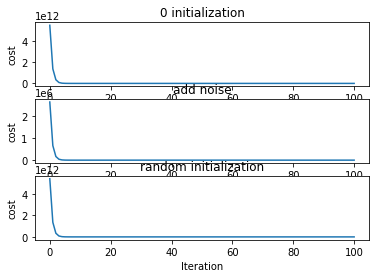

In [9]:
def residual(points_2d, points_3d, P):
    res = []
    P = P.reshape((3,4))
    for i in range(points_2d.shape[0]):
        res.append(np.sum((points_2d[i] - np.matmul(P,points_3d[i]))**2))
    return np.array(res)

def jacobian(points_2d, points_3d, P):
    
    J = np.zeros((points_2d.shape[0], 12))
    
    a = 2*(points_2d[:,0] - P[0]*points_3d[:,0] - P[1]*points_3d[:,1] - P[2]*points_3d[:,2] - P[3]*points_3d[:,3])
    b = 2*(points_2d[:,1] - P[4]*points_3d[:,0] - P[5]*points_3d[:,1] - P[6]*points_3d[:,2] - P[7]*points_3d[:,3])
    c = 2*(points_2d[:,2] - P[8]*points_3d[:,0] - P[9]*points_3d[:,1] - P[10]*points_3d[:,2] - P[11]*points_3d[:,3])
        
    J[:,0] = -a*points_3d[:,0]
    J[:,1] = -a*points_3d[:,1]
    J[:,2] = -a*points_3d[:,2]
    J[:,3] = -a*points_3d[:,3]
    J[:,4] = -b*points_3d[:,0]
    J[:,5] = -b*points_3d[:,1]
    J[:,6] = -b*points_3d[:,2]
    J[:,7] = -b*points_3d[:,3]
    J[:,8] = -c*points_3d[:,0]
    J[:,9] = -c*points_3d[:,1]
    J[:,10] = -c*points_3d[:,2]
    J[:,11] = -c*points_3d[:,3]
    
    return J

def gauss_newton(points_2d,points_3d,proj):
    
    initial_err = np.sum(residual(points_2d, points_3d, proj))

    err = [initial_err]

    num_iter = 100
    
    i = 0

    while i < num_iter:

        J = jacobian(points_2d, points_3d, proj)

        e = residual(points_2d, points_3d, proj)

        derv = -np.matmul(np.linalg.pinv(np.matmul(J.T,J)),np.matmul(J.T,e))

        proj += derv.reshape((12,1))

        err.append(np.sum(residual(points_2d, points_3d, proj)))

        i = i + 1
        
    return proj,err



proj1 = np.zeros((12,1)) ### zero initialization
proj2 = P.reshape((12,1)) + np.random.normal(0, 1, (12,1)) ### adding noise
proj3 = np.random.randn(4,3).reshape((12,1)) ### random initialization    

_,err1 = gauss_newton(points_2d,points_3d,proj1)
    
plt.subplot(3,1,1)
plt.xlabel("Iteration")
plt.ylabel("cost")
plt.title("0 initialization")
plt.plot(err1)

_,err2 = gauss_newton(points_2d,points_3d,proj2)

plt.subplot(3,1,2)
plt.xlabel("Iteration")
plt.ylabel("cost")
plt.title("add noise")
plt.plot(err2)

_,err3 = gauss_newton(points_2d,points_3d,proj3)

plt.subplot(3,1,3)
plt.xlabel("Iteration")
plt.ylabel("cost")
plt.title("random initialization")
plt.plot(err3)


## PART 3: Odometry Calculation

In part 1, you used the ground truth pose for registration. Here, try to estimate the pose using the RGB image data alone. 

#### Procedure:

1. This can be done by computing features across the two images and matching them. Since you already have the depth map, you now have correspondences between the depth maps of two images as well from the RGB feature matches. 
2. You can now convert this depth map to a point cloud.
3. Since you have correspondences between image points in the depth map, you have 3D correspondences here as well. Perform ICP here to get a good pose estimate.
4. Feed these initial pose estimates into the PnP pipeline and optimise further.

In [10]:
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

img_list = sorted(os.listdir('../data/img2'))




focal_length = 7.070912e+02
k = np.float32([[7.070912e+02, 0.000000e+00, 6.018873e+02], 
     [0.000000e+00, 7.070912e+02, 1.831104e+02], 
     [0.000000e+00, 0.000000e+00, 1.000000e+00]])
baseline = 0.53790448812
win_size = 3
min_disp = 16
max_disp = 144
num_disp =max_disp -min_disp

In [11]:
def procrustes(x,y):
    n = x.shape[0]
    x0 = np.sum(x,axis=0)/n
    y0 = np.sum(y,axis=0)/n
    H = np.matmul((x-x0).T,y-y0)
    u,s,vh = np.linalg.svd(H)
    R = np.matmul(vh.T,u.T)
    t = y0 - np.matmul(R,x0)
    T = np.empty((4,4))
    T[:3,:3] = R
    T[:3,3] = t
    T[3,:] = np.array([0,0,0,1])
    
    return T

[ WARN:0] global /tmp/pip-req-build-6qnmwb6g/opencv_contrib/modules/xfeatures2d/misc/python/shadow_sift.hpp (13) SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


[(575.5266723632812, 132.70054626464844), (377.94757080078125, 226.1036834716797), (451.3332214355469, 25.33942222595215), (236.009521484375, 53.31407165527344), (822.847900390625, 138.6542205810547)] [(610.8673095703125, 132.26622009277344), (408.4986572265625, 226.99880981445312), (485.4169616699219, 22.878087997436523), (272.5467529296875, 51.85313415527344), (862.7445678710938, 140.8159942626953)]


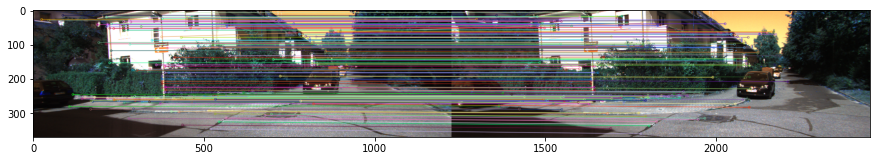

Transformation matrix to go from 0th frame to 1th frame is 
 [[ 0.99858296  0.01066383 -0.05213952 -0.05152491]
 [-0.0101811   0.9999029   0.00951512 -0.09019685]
 [ 0.05223592 -0.00897077  0.99859452 -0.44245625]
 [ 0.          0.          0.          1.        ]] 

[(824.9038696289062, 67.08482360839844), (801.1906127929688, 39.65496063232422), (408.4986572265625, 226.99880981445312), (407.8157653808594, 214.5508270263672), (856.3967895507812, 133.6265106201172)] [(866.891845703125, 68.08201599121094), (841.385986328125, 39.95103454589844), (440.48724365234375, 230.05203247070312), (439.86798095703125, 217.00633239746094), (899.489013671875, 136.80862426757812)]


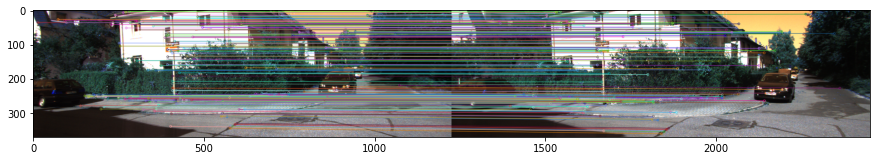

Transformation matrix to go from 1th frame to 2th frame is 
 [[ 0.99926156  0.00694257 -0.03778978  0.03025162]
 [-0.00706838  0.9999699  -0.00319662  0.10966602]
 [ 0.03776646  0.00346138  0.99928063 -0.47053909]
 [ 0.          0.          0.          1.        ]] 

[(448.20526123046875, 243.65768432617188), (474.25408935546875, 268.2716979980469), (120.23152160644531, 28.9438533782959), (330.6636962890625, 46.82281494140625), (337.1898498535156, 57.88054275512695)] [(481.6319885253906, 246.47854614257812), (508.2755126953125, 272.3393859863281), (165.193115234375, 31.945035934448242), (366.6022644042969, 46.89014434814453), (373.0224914550781, 58.04405212402344)]


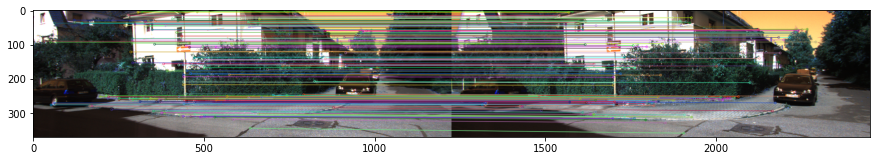

Transformation matrix to go from 2th frame to 3th frame is 
 [[ 9.99050260e-01  9.55539804e-07 -4.35721017e-02 -9.03900266e-02]
 [ 9.24898268e-05  9.99997735e-01  2.14249012e-03 -1.03656203e-02]
 [ 4.35719900e-02 -2.14448827e-03  9.99048054e-01 -4.69364166e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] 

[(473.7314758300781, 189.21832275390625), (231.44430541992188, 252.2125244140625), (326.57244873046875, 97.12242889404297), (389.025390625, 28.944311141967773), (459.10528564453125, 29.650211334228516)] [(508.2488708496094, 189.0211181640625), (265.86279296875, 251.7258758544922), (362.7240295410156, 96.57608032226562), (424.2098083496094, 26.963945388793945), (494.2841796875, 26.628767013549805)]


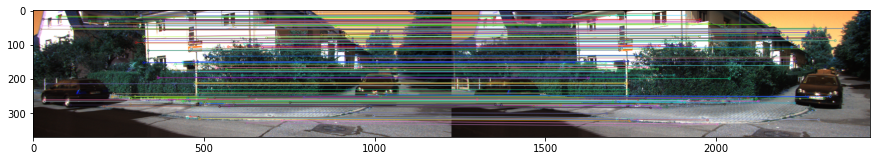

Transformation matrix to go from 3th frame to 4th frame is 
 [[ 0.9984901   0.00422646 -0.05476944  0.09379771]
 [-0.0039632   0.99998009  0.00491417 -0.04540066]
 [ 0.0547891  -0.00468969  0.998487   -0.46540546]
 [ 0.          0.          0.          1.        ]] 

[(44.27783203125, 212.36549377441406), (507.840087890625, 177.1599578857422), (408.6232604980469, 56.64420700073242), (508.926513671875, 199.3736572265625), (420.0219421386719, 54.9318962097168)] [(91.37931823730469, 210.09877014160156), (543.3218994140625, 175.68031311035156), (443.62091064453125, 53.88532257080078), (544.4532470703125, 198.5905303955078), (454.9743347167969, 51.98652267456055)]


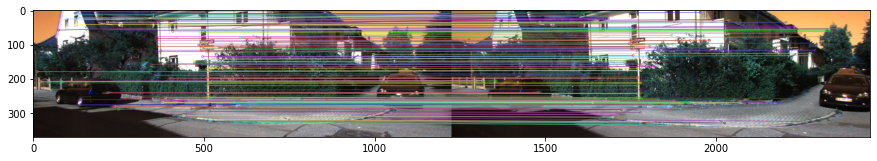

Transformation matrix to go from 4th frame to 5th frame is 
 [[ 0.99912    -0.00496651 -0.04164674 -0.14963832]
 [ 0.00472121  0.99997097 -0.00598594  0.08931066]
 [ 0.0416753   0.00578405  0.99911451 -0.57044315]
 [ 0.          0.          0.          1.        ]] 

[(444.3348693847656, 151.19332885742188), (364.7483825683594, 264.622314453125), (399.4623107910156, 104.1412353515625), (490.31781005859375, 184.7110137939453), (587.6195678710938, 277.14801025390625)] [(480.1151123046875, 147.42376708984375), (398.80194091796875, 261.63677978515625), (436.02972412109375, 99.5308609008789), (526.5384521484375, 181.28712463378906), (626.6539306640625, 279.168212890625)]


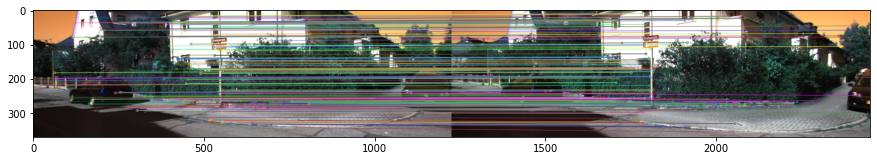

Transformation matrix to go from 5th frame to 6th frame is 
 [[ 0.99886769  0.00236265 -0.04751518 -0.00560409]
 [-0.00297884  0.99991232 -0.01290193  0.13103038]
 [ 0.04748054  0.01302885  0.99878722 -0.43407059]
 [ 0.          0.          0.          1.        ]] 

[(589.2899169921875, 250.08721923828125), (433.0638427734375, 70.55243682861328), (581.917724609375, 178.0330810546875), (480.1151123046875, 147.42376708984375), (369.56109619140625, 285.3039855957031)] [(628.7933349609375, 250.14340209960938), (469.85565185546875, 64.24925994873047), (621.8837280273438, 174.3275909423828), (516.1101684570312, 142.41807556152344), (401.7108459472656, 282.2445373535156)]


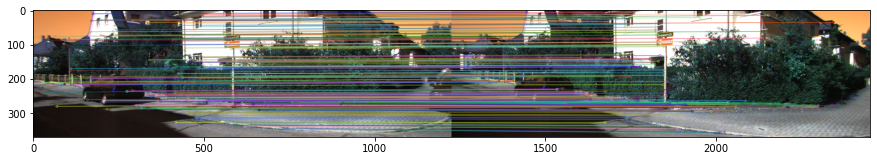

Transformation matrix to go from 6th frame to 7th frame is 
 [[ 0.99846381  0.0101836  -0.05446393 -0.02532485]
 [-0.01073086  0.99989474 -0.00976513  0.08086936]
 [ 0.05435876  0.01033457  0.99846804 -0.53703117]
 [ 0.          0.          0.          1.        ]] 

[(516.1101684570312, 142.41807556152344), (597.1459350585938, 53.31655502319336), (224.37606811523438, 25.790029525756836), (369.7377624511719, 285.72650146484375), (432.7063293457031, 257.8564758300781)] [(553.09130859375, 138.4518585205078), (636.1506958007812, 46.880332946777344), (266.5808410644531, 24.063119888305664), (403.1862487792969, 285.8992919921875), (467.7137145996094, 256.9352111816406)]


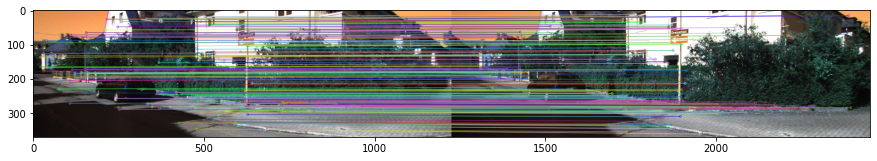

Transformation matrix to go from 7th frame to 8th frame is 
 [[ 9.99296725e-01 -8.76510225e-04 -3.74884270e-02 -6.67278171e-02]
 [ 6.34573691e-04  9.99978960e-01 -6.46521244e-03  6.05520606e-02]
 [ 3.74933593e-02  6.43687835e-03  9.99276102e-01 -4.83346939e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] 

[(458.3315124511719, 248.72828674316406), (501.95025634765625, 327.5594177246094), (403.1862487792969, 285.8992919921875), (667.2839965820312, 210.8690948486328), (323.2611389160156, 65.20085144042969)] [(494.326904296875, 251.63243103027344), (538.58154296875, 337.17474365234375), (437.7732238769531, 290.5107727050781), (712.310791015625, 213.58734130859375), (362.0489807128906, 67.44535827636719)]


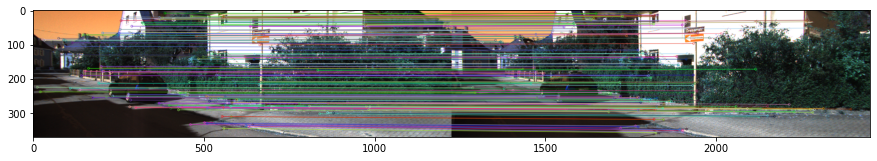

Transformation matrix to go from 8th frame to 9th frame is 
 [[ 9.98711765e-01 -3.47615499e-03 -5.06229922e-02  2.97635198e-02]
 [ 3.46979452e-03  9.99993980e-01 -2.13160951e-04  4.73812819e-02]
 [ 5.06234057e-02  3.72512804e-05  9.98717844e-01 -4.75550652e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] 

[(68.65534210205078, 86.75115966796875), (370.4081726074219, 45.87792205810547), (684.6358032226562, 29.934955596923828), (556.4931640625, 29.340349197387695), (706.09912109375, 210.2795867919922)] [(121.65957641601562, 94.68467712402344), (407.2215576171875, 48.7916374206543), (725.22314453125, 24.985380172729492), (592.4434204101562, 27.631269454956055), (753.89453125, 212.45980834960938)]


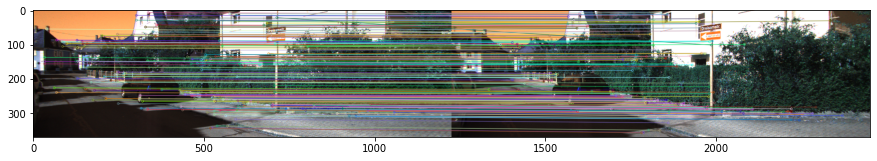

Transformation matrix to go from 9th frame to 10th frame is 
 [[ 9.98614550e-01  5.01043338e-04 -5.26193045e-02  7.47363567e-02]
 [-1.91059095e-04  9.99982655e-01  5.89573290e-03 -1.66631807e-02]
 [ 5.26213460e-02 -5.87746920e-03  9.98597205e-01 -4.61982727e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] 

[(136.07110595703125, 105.17768096923828), (89.19776916503906, 167.28819274902344), (627.632080078125, 140.2121124267578), (558.6085815429688, 242.01626586914062), (88.63794708251953, 143.8961181640625)] [(184.99874877929688, 110.06248474121094), (140.62652587890625, 170.60610961914062), (666.4946899414062, 138.66360473632812), (596.3341674804688, 246.39328002929688), (140.12464904785156, 147.89517211914062)]


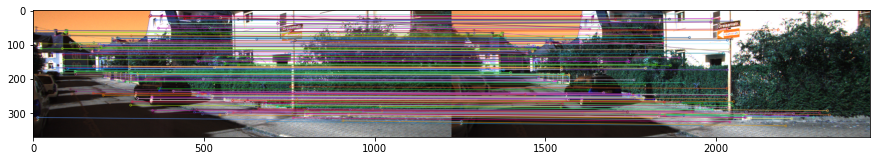

Transformation matrix to go from 10th frame to 11th frame is 
 [[ 0.99868816 -0.00188362 -0.05116966  0.07192397]
 [ 0.00227045  0.9999693   0.00750298 -0.03053398]
 [ 0.05115394 -0.00760927  0.99866182 -0.40482807]
 [ 0.          0.          0.          1.        ]] 

[(445.94146728515625, 52.175682067871094), (615.75830078125, 80.13672637939453), (154.70326232910156, 247.0491180419922), (148.55311584472656, 88.80482482910156), (446.5591125488281, 289.6399841308594)] [(481.9261474609375, 52.69337463378906), (653.896484375, 78.9364242553711), (194.69781494140625, 248.07528686523438), (196.13365173339844, 92.46730041503906), (480.71929931640625, 294.6368408203125)]


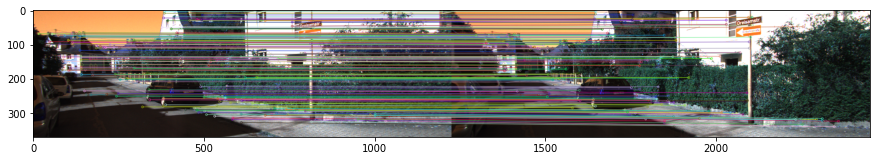

Transformation matrix to go from 11th frame to 12th frame is 
 [[ 9.98788536e-01 -4.78343200e-03 -4.89754826e-02  6.86916113e-02]
 [ 4.80213296e-03  9.99988377e-01  2.63593713e-04  2.10735351e-02]
 [ 4.89736833e-02 -4.98485635e-04  9.98799980e-01 -3.49026680e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] 

[(187.6604766845703, 145.36419677734375), (187.60711669921875, 141.0023651123047), (459.1150207519531, 21.089950561523438), (516.0861206054688, 27.05735206604004), (187.88311767578125, 154.46694946289062)] [(232.62420654296875, 147.20635986328125), (232.51805114746094, 142.59461975097656), (495.2701416015625, 21.86729621887207), (551.9876708984375, 27.094236373901367), (232.7616729736328, 155.8863525390625)]


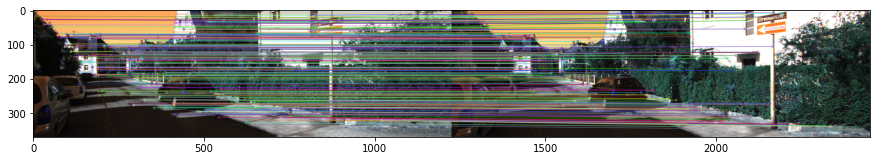

Transformation matrix to go from 12th frame to 13th frame is 
 [[ 0.99852955  0.00353603 -0.05409552  0.10852087]
 [-0.00330089  0.99998474  0.00443609 -0.0388242 ]
 [ 0.05411042 -0.00425092  0.99852586 -0.29894638]
 [ 0.          0.          0.          1.        ]] 

[(495.2701416015625, 21.86729621887207), (269.00042724609375, 108.65943908691406), (232.64454650878906, 151.58595275878906), (275.6138610839844, 122.28762817382812), (353.4186096191406, 200.75762939453125)] [(531.4329223632812, 21.740135192871094), (310.8750915527344, 111.0658187866211), (276.1203308105469, 153.35284423828125), (317.33575439453125, 124.53902435302734), (391.4355163574219, 201.7824249267578)]


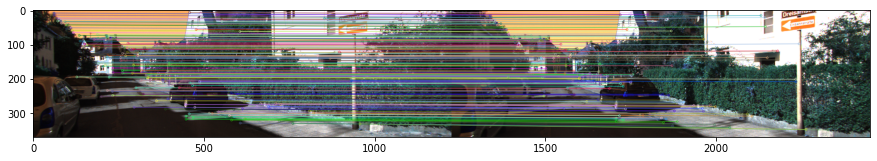

Transformation matrix to go from 13th frame to 14th frame is 
 [[ 0.99864012  0.00184852 -0.05210019  0.04008937]
 [-0.00177644  0.99999738  0.00143002  0.04740342]
 [ 0.05210269 -0.00133551  0.99864084 -0.40429306]
 [ 0.          0.          0.          1.        ]] 

[(317.33575439453125, 124.53902435302734), (291.3270568847656, 90.32581329345703), (351.7546081542969, 162.6285858154297), (124.0743179321289, 37.63582992553711), (275.9081115722656, 148.8943328857422)] [(357.2910461425781, 126.63207244873047), (332.1560363769531, 93.24607849121094), (390.7467041015625, 164.07684326171875), (172.22018432617188, 43.71498489379883), (317.4209899902344, 150.92369079589844)]


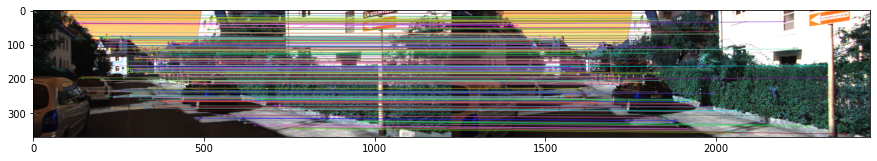

Transformation matrix to go from 14th frame to 15th frame is 
 [[ 9.98434067e-01  5.39120410e-05 -5.59421144e-02  1.93574667e-01]
 [-2.36754895e-05  9.99999881e-01  5.41873160e-04 -1.78719349e-02]
 [ 5.59421256e-02 -5.39671048e-04  9.98433828e-01 -1.54176712e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] 

[(564.0521240234375, 81.63059997558594), (296.7113952636719, 236.24038696289062), (344.5838623046875, 130.01068115234375), (405.2882080078125, 118.3126449584961), (390.7467041015625, 164.07684326171875)] [(597.4999389648438, 80.78866577148438), (331.1913757324219, 237.125244140625), (380.7060546875, 131.3653106689453), (440.3390197753906, 119.48611450195312), (425.739013671875, 164.84182739257812)]


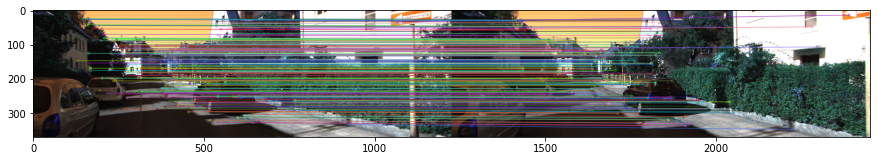

Transformation matrix to go from 15th frame to 16th frame is 
 [[ 9.98424947e-01  1.93215115e-03 -5.60716726e-02  7.52714872e-02]
 [-1.88220514e-03  9.99997795e-01  9.43376857e-04  2.94767581e-02]
 [ 5.60733341e-02 -8.36356892e-04  9.98426259e-01 -4.35252190e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] 

[(361.9558410644531, 102.7155990600586), (382.142822265625, 144.09689331054688), (212.44113159179688, 39.841854095458984), (296.5016174316406, 101.4553451538086), (572.06201171875, 31.823177337646484)] [(396.0122375488281, 100.32876586914062), (415.69586181640625, 141.51467895507812), (251.33511352539062, 38.7322998046875), (332.5470886230469, 99.3213882446289), (605.0299682617188, 27.93829917907715)]


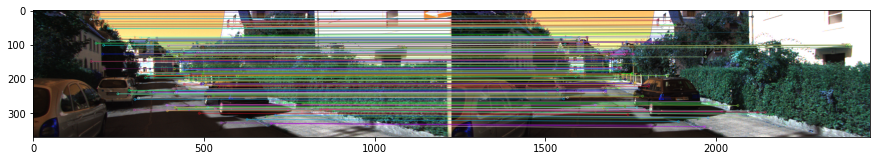

Transformation matrix to go from 16th frame to 17th frame is 
 [[ 0.99916983  0.01250668 -0.03877088 -0.03055418]
 [-0.01232407  0.99991184  0.00494503 -0.10094635]
 [ 0.0388293  -0.00446312  0.99923587 -0.30479813]
 [ 0.          0.          0.          1.        ]] 

[(491.7518005371094, 179.161376953125), (208.21405029296875, 146.13880920410156), (242.1599578857422, 153.6995849609375), (374.9638977050781, 237.49856567382812), (414.3158264160156, 128.8380584716797)] [(521.6182861328125, 175.38255310058594), (242.18675231933594, 142.04666137695312), (275.8855285644531, 149.7068328857422), (404.1392822265625, 233.8744354248047), (445.3861999511719, 125.05243682861328)]


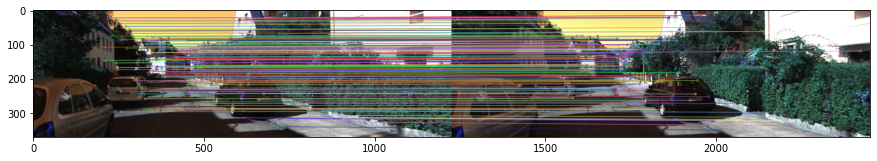

Transformation matrix to go from 17th frame to 18th frame is 
 [[ 9.99033809e-01  2.90809141e-04 -4.39460538e-02  7.76031017e-02]
 [-4.89086902e-04  9.99989748e-01 -4.50087385e-03 -1.40637457e-02]
 [ 4.39442806e-02  4.51801391e-03  9.99023795e-01 -2.60593414e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] 

[(365.2054138183594, 95.86649322509766), (392.2605285644531, 230.68307495117188), (275.8855285644531, 149.7068328857422), (392.2605285644531, 230.68307495117188), (355.2333068847656, 124.23676300048828)] [(393.3213806152344, 93.87504577636719), (418.0942687988281, 228.72450256347656), (304.7842102050781, 147.59536743164062), (418.0942687988281, 228.72450256347656), (383.2677307128906, 122.37158203125)]


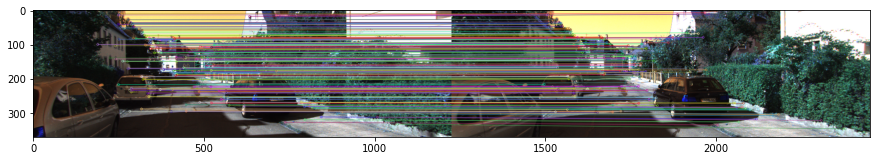

Transformation matrix to go from 18th frame to 19th frame is 
 [[ 0.99954778 -0.00648081 -0.02936476 -0.07247496]
 [ 0.00639405  0.99997491 -0.00304813 -0.00975281]
 [ 0.02938377  0.00285898  0.99956411 -0.24748039]
 [ 0.          0.          0.          1.        ]] 

[(410.6625061035156, 88.10333251953125), (334.2688903808594, 43.75459671020508), (447.1228942871094, 142.85462951660156), (498.0386657714844, 221.2164306640625), (361.6445617675781, 81.68228912353516)] [(434.6932067871094, 86.94844055175781), (358.7691955566406, 43.780975341796875), (470.9486389160156, 145.55735778808594), (521.1337280273438, 220.22982788085938), (386.01080322265625, 80.99453735351562)]


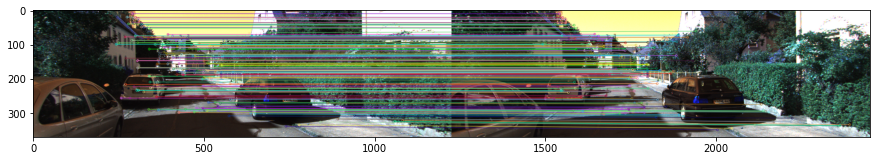

Transformation matrix to go from 19th frame to 20th frame is 
 [[ 9.99518454e-01 -3.62903997e-03 -3.08167674e-02  4.21469212e-02]
 [ 3.64262774e-03  9.99993265e-01  3.84724088e-04 -2.39056051e-02]
 [ 3.08151674e-02 -4.96818917e-04  9.99524951e-01 -3.49378586e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] 



In [12]:
for knt,img in enumerate(img_list):
    if knt == len(img_list)-1:
        continue
    img1 = cv2.imread('../data/img2/'+img_list[knt])  
    img2 = cv2.imread('../data/img2/'+img_list[knt+1])
    sift = cv2.xfeatures2d.SIFT_create()

    kp1, descriptors_1 = sift.detectAndCompute(img1,None)
    kp2, descriptors_2 = sift.detectAndCompute(img2,None)


    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

    matches = bf.match(descriptors_1,descriptors_2)
    matches = sorted(matches, key = lambda x:x.distance)
    
    list_kp1 = []
    list_kp2 = []

    for mat in matches:

        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        (x1, y1) = kp1[img1_idx].pt
        (x2, y2) = kp2[img2_idx].pt

        list_kp1.append((y1, x1))
        list_kp2.append((y2, x2))
    
    list_kp1 = [kp1[mat.queryIdx].pt for mat in matches] 
    list_kp2 = [kp2[mat.trainIdx].pt for mat in matches]
    
    print(list_kp1[:5],list_kp2[:5])
    
    img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:200], img2, flags=2)
    
    
    plt.figure(figsize=(15,20))
    plt.imshow(img3),plt.show()
    
    
    img1_left = cv2.imread('../data/img2/'+img_list[knt])
    img1_right = cv2.imread('../data/img3/'+img_list[knt])
    
    stereo1 = cv2.StereoSGBM_create(minDisparity = min_disp,
       numDisparities = num_disp,
       blockSize = 7,
       disp12MaxDiff = 1,
       speckleWindowSize = 400,
       speckleRange = 5,
       uniquenessRatio = 12,
       P1 = 8*3*win_size**2,
       P2 = 32*3*win_size**2,
    )
    disparity_map = stereo1.compute(img1_left, img1_right).astype(np.float32) / 16.0
    
    h, w = img1_left.shape[:2]
    Height = h
    Width = w

    Q = np.float32([[1, 0, 0, -0.5*w],
                    [0,-1, 0,  0.5*h], 
                    [0, 0, 0, -focal_length], 
                    [0, 0, -1/baseline,  0]])
    
    points1 = cv2.reprojectImageTo3D(disparity_map, Q)
    mask1 = disparity_map > disparity_map.min()

    
    img2_left = cv2.imread('../data/img2/'+img_list[knt+1])
    img2_right = cv2.imread('../data/img3/'+img_list[knt+1])
    

    stereo2 = cv2.StereoSGBM_create(minDisparity = min_disp,
       numDisparities = num_disp,
       blockSize = 7,
       disp12MaxDiff = 1,
       speckleWindowSize = 400,
       speckleRange = 5,
       uniquenessRatio = 12,
       P1 = 8*3*win_size**2,
       P2 = 32*3*win_size**2,
    )
    disparity_map = stereo2.compute(img2_left, img2_right).astype(np.float32) / 16.0
    h, w = img1_left.shape[:2]
    Height = h
    Width = w

    Q = np.float32([[1, 0, 0, -0.5*w],
                    [0,-1, 0,  0.5*h], 
                    [0, 0, 0, -focal_length], 
                    [0, 0, -1/baseline,  0]])

    points2 = cv2.reprojectImageTo3D(disparity_map, Q)
    mask2 = disparity_map > disparity_map.min()

    corresponding_points = []
     
    for cnt,match in enumerate(list_kp1):
        row1 = int(match[1])-1
        col1 = int(match[0])-1
        row2 = int(list_kp2[cnt][1])-1
        col2 = int(list_kp2[cnt][0])-1
        found = False
        for i in range(-3,3):
            if found:
                break
            for j in range(-3,3):
                if(found):
                    break
                if (row1+i>h and row2+i>h and col1+j>w and col2+j>w and row1+i<0 and row2+i<0 and col1+j<0 and col2+j<0  ):
                    continue
                if(mask1[row1+i][col1+j] and mask2[row2+i][col2+j]):
                    corresponding_points.append([points1[row1+i][col1+j] , points2[row2+i][col2+j]])
                    found = True
                    
                    
    corresponding_points = np.array(corresponding_points)
   
    T = procrustes(corresponding_points[:,0,:],corresponding_points[:,1,:])
    
    print(f"Transformation matrix to go from {knt}th frame to {knt+1}th frame is \n {T} \n")
    
    
    